In [1]:
import torch
from models import my_vgg

def validate(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d ' % (100 * correct / total))
    return loss_sum / total, correct / total

def validate_ensemble(model_1, model_2, testloader, criterion, device):
    model_1.eval()
    model_2.eval()

    correct = 0
    total = 0
    loss_sum = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs_1 = model_1(images)
            outputs_2 = model_2(images)
            
            # Average the outputs
            outputs = (outputs_1 + outputs_2) / 2
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the ensemble on the 10000 test images: %d ' % (100 * correct / total))
    return loss_sum / total, correct / total

/home/xingyu/anaconda3/envs/test_ffcv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch

torch.cuda.is_available()

True

In [6]:
from utils import prepare_data

config = {'dataset': {'name': 'cifar10'}}

loaders = prepare_data(config['dataset'])

trainloader = loaders['train']['full']
testloader = loaders['test']['full']

Files already downloaded and verified
Files already downloaded and verified


In [7]:
sd_1 = torch.load('checkpoints/cifar10_my_vgg16_1.pt', weights_only=True, map_location='cpu')
sd_2 = torch.load('checkpoints/cifar10_my_vgg16_2.pt', weights_only=True, map_location='cpu')
sd_zipit = torch.load('checkpoints/cifar10_my_vgg16_zipit_1_2.pt', weights_only=True, map_location='cpu')

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/cifar10_my_vgg16_zipit_1_2.pt'

In [ ]:
model_1 = my_vgg.my_vgg16()
model_1.load_state_dict(sd_1)
model_1 = model_1.to(0)

model_2 = my_vgg.my_vgg16()
model_2.load_state_dict(sd_2)
model_2 = model_2.to(0)

/home/xingyu/anaconda3/envs/default/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## whether we have the same bias issue

In [ ]:
import torch
from models import my_vgg
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from lmc_utils import interpolate_state_dicts, repair

sd_1 = torch.load('checkpoints/cifar10_my_vgg16_1.pt', weights_only=True, map_location='cpu')
sd_2 = torch.load('checkpoints/cifar10_my_vgg16_2.pt', weights_only=True, map_location='cpu')
sd_zipit = torch.load('checkpoints/cifar10_my_vgg16_zipit_1_2.pt', weights_only=True, map_location='cpu')
criterion = torch.nn.CrossEntropyLoss()
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model_1, model_2 = my_vgg.my_vgg16(), my_vgg.my_vgg16()
model_1.load_state_dict(sd_1)
model_2.load_state_dict(sd_2)
model_1, model_2 = model_1.to(device), model_2.to(device)


model_zipit = my_vgg.my_vgg16()
model_zipit.load_state_dict(sd_zipit)
model_zipit = model_zipit.to(device)

In [ ]:
keys = list(sd_1.keys())
bias_keys = []
for k in keys:
    if 'bias' in k:
        bias_keys.append(k)
bias_keys = np.array(bias_keys)


forward_test_acc_s = []
forward_test_loss_s = []


model_zipit_removebias = my_vgg.my_vgg16()
for i in range(len(bias_keys)+1):
    sd_zipt_removebias = deepcopy(sd_zipit)
    for k in bias_keys[:i]:
        if 'bias' in k:
            sd_zipt_removebias[k].fill_(0)
    model_zipit_removebias.load_state_dict(sd_zipt_removebias)
    loss, acc = validate(model_zipit_removebias, testloader, criterion)
    forward_test_acc_s.append(acc)
    forward_test_loss_s.append(loss)

backward_test_acc_s = [forward_test_acc_s[0]]
backward_test_loss_s = [forward_test_loss_s[0]]
for i in range(1, len(bias_keys)+1):
    sd_zipt_removebias = deepcopy(sd_zipit)
    for k in bias_keys[-i:]:
        if 'bias' in k:
            sd_zipt_removebias[k].fill_(0)
    model_zipit_removebias.load_state_dict(sd_zipt_removebias)
    loss, acc = validate(model_zipit_removebias, testloader, criterion)
    backward_test_acc_s.append(acc)
    backward_test_loss_s.append(loss)

forward_test_acc_s = np.array(forward_test_acc_s)
forward_test_loss_s = np.array(forward_test_loss_s)
backward_test_acc_s = np.array(backward_test_acc_s)
backward_test_loss_s = np.array(backward_test_loss_s)

Accuracy of the network on the 10000 test images: 40 %
Accuracy of the network on the 10000 test images: 13 %
Accuracy of the network on the 10000 test images: 13 %
Accuracy of the network on the 10000 test images: 12 %
Accuracy of the network on the 10000 test images: 12 %
Accuracy of the network on the 10000 test images: 12 %
Accuracy of the network on the 10000 test images: 12 %
Accuracy of the network on the 10000 test images: 12 %
Accuracy of the network on the 10000 test images: 12 %
Accuracy of the network on the 10000 test images: 12 %
Accuracy of the network on the 10000 test images: 12 %
Accuracy of the network on the 10000 test images: 13 %
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 13 %
Accuracy of the network on the 10000 test images: 53 %
Accuracy of the network on the 10000 test images: 39 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 74 %
Accuracy o

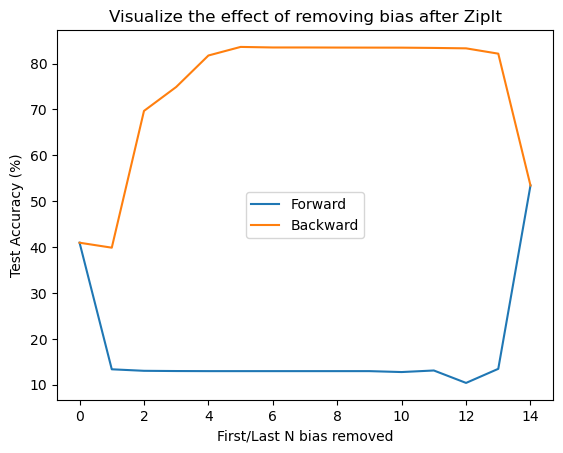

In [ ]:
plt.plot(forward_test_acc_s*100, label='Forward')
plt.plot(backward_test_acc_s*100, label='Backward')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('First/Last N bias removed')
plt.title('Visualize the effect of removing bias after ZipIt')
plt.legend()

In [ ]:
model_zipit_repaired = repair(trainloader, [model_1, model_2], model_zipit, device, variant='rescale')

Resetting batch norm:   0%|          | 0/391 [00:00<?, ?it/s]

Resetting batch norm:   0%|          | 0/391 [00:00<?, ?it/s]

goal_mean: tensor([-0.8369,  0.0675, -0.4505, -0.4128, -0.3135, -0.1085, -0.5877, -0.4642,
        -0.5270, -0.3620, -0.0630,  0.1351, -0.9242, -0.9488, -1.2758, -0.1868,
        -0.6932, -0.6036, -0.9778, -0.4735, -0.6030, -0.1383, -0.6388, -1.2790,
        -1.2080, -1.2704, -0.5989, -1.0217, -0.9551, -0.4458, -1.1198, -0.7414,
        -0.7237, -0.4331, -0.4213, -1.1057, -0.7119,  0.0935, -1.1474, -0.6130,
        -0.0667, -0.7024,  0.5033, -0.7686, -0.5042, -0.6589, -0.7587, -1.2202,
        -0.0178, -1.4005, -0.6380, -1.3187, -0.7804, -1.4862, -0.2236, -0.0557,
        -1.0658, -0.9072, -0.7474, -0.9934, -1.2893,  0.0954, -0.4475, -0.2355],
       device='cuda:0')
goal_std: tensor([2.2296, 1.7136, 1.5926, 1.5297, 1.1061, 1.8966, 1.2593, 1.2129, 1.3019,
        2.3067, 1.4146, 1.4794, 1.6958, 1.9995, 1.4476, 1.6936, 1.6551, 2.7267,
        1.9669, 1.4772, 1.6346, 1.7650, 2.1261, 1.6525, 1.5199, 2.6940, 2.3985,
        1.4581, 1.8517, 2.0845, 1.6581, 1.8937, 1.0183, 1.8175, 1.4368, 1.

In [ ]:
model_zipit_removebias.load_state_dict(sd_zipit)
validate(model_zipit_removebias, testloader, criterion)

Accuracy of the network on the 10000 test images: 10 %


(0.021593576431274415, 0.1)

In [ ]:
validate(model_zipit_repaired, testloader, criterion, device)

Accuracy of the network on the 10000 test images: 75 %


(85948263327.3344, 0.753)

check the weights of merged model

In [ ]:
sd_permute = torch.load('checkpoints/cifar10_my_vgg16_permute_1_2.pt', weights_only=True, map_location='cpu')
model_permute = my_vgg.my_vgg16()
model_permute.load_state_dict(sd_permute)
model_permute = model_permute.to(device)

In [ ]:
validate_ensemble(model_1, model_2, testloader, criterion, device)

Accuracy of the ensemble on the 10000 test images: 93 


(0.002912820114940405, 0.9327)

In [ ]:
sd_permute.keys()

dict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias'])

In [ ]:
# for key in sd_permute.keys():
#     print(key)
#     mid_value = (sd_1[key] + sd_2[key]) / 2
#     permute_value = sd_permute[key]
#     assert torch.allclose(mid_value, permute_value)

check the graph

In [ ]:
from graphs.my_vgg_graph import my_vgg16
from copy import deepcopy

# graph_1 = my_vgg16(deepcopy(model_1)).graphify()
# graph_1.print_prefix()

In [ ]:
from graphs.base_graph import NodeType

def get_prefix(graph):
    prefix_nodes = []
    for node in graph.G.nodes:
        info = graph.get_node_info(node)
        if info['type'] in (NodeType.PREFIX, NodeType.POSTFIX):
            prefix_nodes.append(node)
    return prefix_nodes

In [ ]:
from models import my_vgg

model_1 = my_vgg.my_vgg16()

graph_1 = my_vgg16(deepcopy(model_1)).graphify()

prefix_nodes = get_prefix(graph_1)

prefix_nodes

[3, 6, 10, 13, 17, 20, 23, 27, 30, 33, 37, 40, 43]

In [ ]:
graph_1.G.nodes[1]

{'layer': 'features.0',
 'type': <NodeType.MODULE: 0>,
 'param': None,
 'chunk': None,
 'special_merge': None}

: 

check the number of parameters

In [ ]:
# 打印每一层的weight和bias假期里占模型所有参数的百分比, model_1

total_params = sum(p.numel() for p in model_1.parameters())
cur_params = 0
for name, param in model_1.named_parameters():
    if 'weight' in name:
        cur_params += param.numel()
    if 'bias' in name:
        cur_params += param.numel()
        print(f"{'.'.join(name.split('.')[:-1])}: {cur_params/total_params*100}%")
        cur_params = 0

features.0: 0.012174063565188102%
features.2: 0.2508726670397691%
features.5: 0.5017453340795383%
features.7: 1.0026210921901344%
features.10: 2.005242184380269%
features.12: 4.008745216822654%
features.14: 4.008745216822654%
features.17: 8.017490433645309%
features.19: 16.031502563414847%
features.21: 16.031502563414847%
features.24: 16.031502563414847%
features.26: 16.031502563414847%
features.28: 16.031502563414847%
classifier.0: 0.034850974380253884%


## understand the code

In [ ]:
import os
import torch
import random

from copy import deepcopy
from tqdm.auto import tqdm
import numpy as np

from utils import *
from model_merger import ModelMerge

In [ ]:
config_name = 'cifar10_my_vgg16'
skip_pair_idxs = []
merging_fns = [
    'match_tensors_permute',
    # 'match_tensors_identity',
]

stop_at = None

device = 'cuda' if torch.cuda.is_available() else 'cpu'
raw_config = get_config_from_name(config_name, device=device)  # 返回config文件中的字典，添加了一个device键值对

csv_file = os.path.join(
    './csvs',
    raw_config['dataset']['name'],
    raw_config['model']['name'],
    raw_config['eval_type'],
    'auxiliary_functions.csv'
)
os.makedirs(os.path.dirname(csv_file), exist_ok=True)

In [ ]:
prefix_nodes = [3, 6, 10, 13, 17, 20, 23, 27, 30, 33, 37, 40, 43]

cur_config = deepcopy(raw_config)

start_at = prefix_nodes[3]
stop_at = None

merging_fn = 'match_tensors_permute'

In [ ]:
config = prepare_experiment_config(cur_config)
train_loader = config['data']['train']['full']
base_models = [reset_bn_stats(base_model, train_loader) for base_model in config['models']['bases']]

Grapher = config['graph']
graphs = [Grapher(deepcopy(base_model)).graphify() for base_model in base_models]
Merge = ModelMerge(*graphs, device=device)

Files already downloaded and verified
Files already downloaded and verified


Preparing Models:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
Merge.transform(
    deepcopy(config['models']['new']), 
    train_loader, 
    transform_fn=get_merging_fn(merging_fn),
    metric_classes=config['metric_fns'],
    stop_at=stop_at,
    start_at=start_at
)

Forward Pass to Compute Merge Metrics:   0%|          | 0/391 [00:00<?, ?it/s]

Computing transformations:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
# Merge.stop_at = stop_at
# Merge.start_at = start_at
# model = deepcopy(config['models']['new'])
# Merge.merged_model = model.to(Merge.device)

# metric_classes=config['metric_fns']
# if not isinstance(metric_classes, dict):
#     metric_classes = { x.name: x for x in metric_classes }

# Merge.metric_classes = metric_classes
# transform_fn=get_merging_fn(merging_fn)
# Merge.transform_fn = transform_fn
# Merge.prune_threshold = 1.0

# if not isinstance(metric_classes, dict):
#     metric_classes = { x.name: x for x in metric_classes }
# prune_threshold = 1.0

# Merge.compute_metrics(train_loader, metric_classes=metric_classes)
# Merge.compute_transformations(transform_fn,
#                             reduce_ratio=1 - 1. / len(Merge.graphs),
#                             prune_threshold=prune_threshold,
#                             start_at=start_at,
#                             stop_at=stop_at
#                             )
# Merge.apply_transformations()

# Merge.add_hooks()

Forward Pass to Compute Merge Metrics:   0%|          | 0/391 [00:00<?, ?it/s]

Computing transformations:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
# from model_merger import MergedModelStop
# import types


# def forward(self, x, cat_dim=None, start_idx=None):
#     """ Evaluate the combined model. """
#     if self.start_at is not None:
#         start_val = defaultdict(lambda: 0)
#         total = 0

#         for idx, model in enumerate(self.start_at_models):
#             if start_idx is not None and idx != start_idx:
#                 continue

#             try:
#                 model(x)
#             except MergedModelStop as e:
#                 for k, v in e.x.items():
#                     start_val[k] = start_val[k] + v
#                 total += 1
        
#         self.start_at_ptr.clear()
#         for k, v in start_val.items():
#             self.start_at_ptr[k] = v / total / len(self.graphs)
#         x = x[0, None].detach()
        
        
    
#     # try:
#     # print("shape of x", x.shape)
#     out = self.merged_model(x)
#     # print("shape of out", out.shape)
#         # print(out)
#     return out
#     # except MergedModelStop as e:
#     #     self.stop_at_ptr[0] = e.x[0]

#     #     dummy_x = x[0, None].detach()
#     #     out = []
#     #     for idx, model in enumerate(self.head_models):
#     #         out.append(model(dummy_x))

#     #     self.stop_at_ptr[0] = None
        
#     #     if cat_dim is not None:
#     #         out = torch.cat(out, dim=cat_dim)
        
#     #     return out

# setattr(Merge, 'forward', types.MethodType(forward, Merge))

In [ ]:
# class MergeHandler:
#     """ 
#     Handles all (un)merge transformations on top of a graph architecture. merge/unmerge is a dict whose 
#     keys are graph nodes and values are merges/unmerges to be applied at the graph node.
#     """
#     def __init__(self, graph, merge, unmerge):
#         self.graph = graph
#         # (Un)Merge instructions for different kinds of module layers.
#         self.module_handlers = {
#             'BatchNorm2d': self.handle_batchnorm2d,
#             'Conv2d': self.handle_conv2d,
#             'Linear': self.handle_linear,
#             'LayerNorm': self.handle_layernorm,
#             'GELU': self.handle_fn,
#             'AdaptiveAvgPool2d': self.handle_fn,
#             'LeakyReLU': self.handle_fn,
#             'ReLU': self.handle_fn,
#             'Tanh': self.handle_fn,
#             'MaxPool2d': self.handle_fn,
#             'AvgPool2d': self.handle_fn,
#              'SpaceInterceptor': self.handle_linear,
#              'Identity': self.handle_fn
#         }

#         self.merge = merge
#         self.unmerge = unmerge
    
#     def handle_batchnorm2d(self, forward, node, module):
#         """ Apply (un)merge operation to batchnorm parameters. """
#         if forward:
#             # Forward will always be called on a batchnorm, but backward might not be called
#             # So merge the batch norm here.
#             for parameter_name in ['weight', 'bias', 'running_mean', 'running_var']:
#                 parameter = getattr(module, parameter_name)
#                 merge = self.merge if parameter_name != 'running_var' else self.merge # ** 2
#                 parameter.data = merge @ parameter
            
#             for succ in self.graph.succs(node):
#                 self.prop_forward(succ)
#         else:
#             assert len(self.graph.preds(node)) == 1, 'BN expects one predecessor'
#             self.prop_back(self.graph.preds(node)[0])
    
#     def handle_layernorm(self, forward, node, module):
#         """ Apply (un)merge operation to layernorm parameters. """
#         if forward:
#             # Forward will always be called on a norm, so merge here
#             parameter_names = ['weight', 'bias']
#             for parameter_name in parameter_names:
#                 parameter = getattr(module, parameter_name)
#                 parameter.data = self.merge @ parameter
            
#             for succ in self.graph.succs(node):
#                 self.prop_forward(succ)
#         else:
#             assert len(self.graph.preds(node)) == 1, 'LN expects one predecessor'
#             self.prop_back(self.graph.preds(node)[0])

#     def handle_fn(self, forward, node, module):
#         """ Apply (un)merge operation to parameterless layers. """
#         if forward:
#             for succ in self.graph.succs(node):
#                 self.prop_forward(succ)
#         else:
#             assert len(self.graph.preds(node)) == 1, 'Function node expects one predecessor'
#             self.prop_back(self.graph.preds(node)[0])

#     def handle_conv2d(self, forward, node, module):
#         """ Apply (un)merge operation to linear layer parameters. """
#         if forward: # unmerge
#             try:
#                 module.weight.data = torch.einsum('OIHW,IU->OUHW', module.weight, self.unmerge)
#             except:
#                 pdb.set_trace()
#         else: # merge
#             try:
#                 print(f'handle conv2d, node {node}')
#                 module.weight.data = torch.einsum('UO,OIHW->UIHW', self.merge, module.weight)
#             except:
#                 pdb.set_trace()
#             if hasattr(module, 'bias') and module.bias is not None:
#                 module.bias.data = self.merge @ module.bias
    
#     def handle_linear(self, forward, node, module):
#         """ Apply (un)merge operation to linear layer parameters. """
#         if forward: # unmerge
#             module.weight.data = module.weight @ self.unmerge
#         else:
#             info = self.graph.get_node_info(node)

#             lower = 0
#             upper = module.weight.shape[0]

#             if info['chunk'] is not None:
#                 idx, num_chunks = info['chunk']
#                 chunk_size = upper // num_chunks

#                 lower = idx * chunk_size
#                 upper = (idx+1) * chunk_size

#             module.weight.data[lower:upper] = self.merge @ module.weight[lower:upper]
#             if hasattr(module, 'bias') and module.bias is not None:
#                 module.bias.data[lower:upper] = self.merge @ module.bias[lower:upper]

#     def prop_back(self, node):
#         """ Propogate (un)merge metrics backwards through a node graph. """
#         if node in self.graph.merged:
#             return
        
#         info = self.graph.get_node_info(node)
#         print(f'add {node} to merged')
#         self.graph.merged.add(node)
        
#         for succ in self.graph.succs(node):
#             self.prop_forward(succ)
        
#         if info['type'] in (NodeType.OUTPUT, NodeType.INPUT):
#             raise RuntimeError(f'Unexpectedly reached node type {info["type"]} when merging.')
#         elif info['type'] == NodeType.CONCAT:
#             # Also this only works if you concat the same size things together
#             merge = self.merge.chunk(len(self.graph.preds(node)), dim=1)
#             for pred, m in zip(self.graph.preds(node), merge):
#                 MergeHandler(self.graph, m, self.unmerge).prop_back(pred)
#         elif info['type'] == NodeType.MODULE:
#             module = self.graph.get_module(info['layer'])
#             # try:
#             self.module_handlers[module.__class__.__name__](False, node, module)
#             # except:
#             #     pdb.set_trace()
#         elif info['type'] == NodeType.EMBEDDING:
#             param = self.graph.get_parameter(info['param'])
#             self.handle_embedding(False, node, param)
#         else:
#             # Default case (also for SUM)
#             for pred in self.graph.preds(node):
#                 self.prop_back(pred)
    
#     def prop_forward(self, node):
#         """ Propogate (un)merge transformations up a network graph. """
#         if node in self.graph.unmerged:
#             return
        
#         info = self.graph.get_node_info(node)
#         self.graph.unmerged.add(node)
        
#         if info['type'] in (NodeType.OUTPUT, NodeType.INPUT):
#             raise RuntimeError(f'Unexpectedly reached node type {info["type"]} when unmerging.')
#         elif info['type'] == NodeType.MODULE:
#             module = self.graph.get_module(info['layer'])
#             self.module_handlers[module.__class__.__name__](True, node, module)
#         elif info['type'] == NodeType.SUM:
#             for succ in self.graph.succs(node):
#                 self.prop_forward(succ)
#             for pred in self.graph.preds(node):
#                 self.prop_back(pred)
#         elif info['type'] == NodeType.CONCAT:
#             # let's make the assumption that this node is reached in the correct order
#             num_to_concat = len(self.graph.preds(node))

#             if node not in self.graph.working_info:
#                 self.graph.working_info[node] = []
#             self.graph.working_info[node].append(self.unmerge)
            
#             if len(self.graph.working_info[node]) < num_to_concat:
#                 # haven't collected all the info yet, don't finish the unmerge
#                 self.graph.unmerged.remove(node)
#             else:
#                 # finally, we're finished
#                 unmerge = torch.block_diag(*self.graph.working_info[node])
#                 del self.graph.working_info[node]

#                 # be free my little unmerge
#                 new_handler = MergeHandler(self.graph, self.merge, unmerge)
#                 for succ in self.graph.succs(node):
#                     new_handler.prop_forward(succ)

In [ ]:

# from model_merger import MergeHandler

# from graphs.base_graph import NodeType
# for node in Merge.merges:
#     print(node)
#     merges = Merge.merges[node]
#     unmerges = Merge.unmerges[node]
#     for merge, unmerge, graph in zip(merges, unmerges, Merge.graphs):
#         merger = MergeHandler(graph, merge, unmerge)
#         merger.prop_back(node)

10
add 10 to merged
add 9 to merged
add 8 to merged
add 10 to merged
add 9 to merged
add 8 to merged
13
add 13 to merged
add 12 to merged
add 11 to merged
add 13 to merged
add 12 to merged
add 11 to merged
17
add 17 to merged
add 16 to merged
add 15 to merged
add 17 to merged
add 16 to merged
add 15 to merged
20
add 20 to merged
add 19 to merged
add 18 to merged
add 20 to merged
add 19 to merged
add 18 to merged
23
add 23 to merged
add 22 to merged
add 21 to merged
add 23 to merged
add 22 to merged
add 21 to merged
27
add 27 to merged
add 26 to merged
add 25 to merged
add 27 to merged
add 26 to merged
add 25 to merged
30
add 30 to merged
add 29 to merged
add 28 to merged
add 30 to merged
add 29 to merged
add 28 to merged
33
add 33 to merged
add 32 to merged
add 31 to merged
add 33 to merged
add 32 to merged
add 31 to merged
37
add 37 to merged
add 36 to merged
add 35 to merged
add 37 to merged
add 36 to merged
add 35 to merged
40
add 40 to merged
add 39 to merged
add 38 to merged
add 4

In [ ]:
evaluate_model(cur_config['eval_type'], Merge, config)

Evaluating classification model:   0%|          | 0/79 [00:00<?, ?it/s]

{'Accuracy': 0.5481}

#### How does the final model run?

In [ ]:
from models import my_vgg

merged_model = my_vgg.my_vgg16()
merged_sd = Merge.get_merged_state_dict()
merged_model.load_state_dict(merged_sd)
merged_model = merged_model.to(device)

In [ ]:
test_loader = config['data']['test']['full']
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
total = 0
correct = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        images = images
        outputs = Merge(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d ' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 54 


In [ ]:
prefix_nodes = [3, 6, 10, 13, 17, 20, 23, 27, 30, 33, 37, 40, 43]

In [ ]:
def partial_zip_model(x, start_at_models, merged_model, nodes, merge_node):
    merge_node_id = int(nodes[merge_node]['layer'].split('.')[-1])
    coefs = [1/len(start_at_models)] * len(start_at_models)
    unzip_output = None
    for i, start_at_model in enumerate(start_at_models):
        if unzip_output is None:
            unzip_output = start_at_model.features[:merge_node_id+1](x) * coefs[i]
        else:
            unzip_output += start_at_model.features[:merge_node_id+1](x) * coefs[i]
    zip_conv_output = merged_model.features[merge_node_id+1:](unzip_output)
    
    out = merged_model.avgpool(zip_conv_output)
    out = torch.flatten(out, 1)
    out = merged_model.classifier(out)
    return out

In [ ]:
list(Merge.graphs[0].merged)[0]

11

In [ ]:
Merge.clear_hooks()

# validate
correct = 0
total = 0
nodes = graphs[0].G.nodes
merge_node = list(Merge.graphs[0].merged)[0]
# merge_node = prefix_nodes[3]-2
# start_at = 40

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = partial_zip_model(images, Merge.start_at_models, merged_model, nodes, merge_node)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: {} '.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 70.81 


In [ ]:
Merge.clear_hooks()

# validate
correct = 0
total = 0
nodes = graphs[0].G.nodes
merge_node = list(Merge.graphs[0].merged)[0]
# start_at = 40

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = partial_zip_model(images, Merge.start_at_models, merged_model, nodes, merge_node)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d ' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 70 


## Unzipping early layers

In [ ]:

import os
import torch
import random

from copy import deepcopy
from tqdm.auto import tqdm
import numpy as np

from utils import *
from model_merger import ModelMerge

def validate(model, testloader, criterion, device, half=False, num_samples=None):
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            images = images.to(device).float()
            labels = labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {}'.format(100 * correct / total))
    return loss_sum / total, correct / total

config_name = 'imagenet_vgg16'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
raw_config = get_config_from_name(config_name, device=device)  # 返回config文件中的字典，添加了一个device键值对
cur_config = deepcopy(raw_config)
config = prepare_experiment_config(cur_config)

train_loader = config['data']['train']['full']
test_loader = config['data']['test']['full']
test_loader.num_workers = 0


base_models = [reset_bn_stats(base_model, train_loader) for base_model in config['models']['bases']]
Grapher = config['graph']
merging_fn = 'match_tensors_permute'
# merging_fn = 'match_tensors_zipit'

criterion = torch.nn.CrossEntropyLoss()

Preparing Models:   0%|          | 0/2 [00:00<?, ?it/s]/home/xingyu/anaconda3/envs/ffcv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xingyu/anaconda3/envs/ffcv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Preparing Models: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


In [13]:
test_loader.batch_size = 256

In [14]:
loss_0, acc_0 = validate(base_models[0], test_loader, criterion, device)
loss_1, acc_1 = validate(base_models[1], test_loader, criterion, device)

print(f'Base model 0: loss {loss_0}, acc {acc_0}')

print(f'Base model 1: loss {loss_1}, acc {acc_1}')

100%|██████████| 196/196 [19:25<00:00,  5.94s/it]


Accuracy of the network on the 10000 test images: 71 


100%|██████████| 196/196 [19:30<00:00,  5.97s/it]

Accuracy of the network on the 10000 test images: 71 
Base model 0: loss 0.004566262530088424, acc 0.71348
Base model 1: loss 0.004575230697393418, acc 0.7132


In [17]:
# validate ensemble
def validate_ensemble(model_1, model_2, testloader, criterion, device):
    model_1.eval()
    model_2.eval()

    correct = 0
    total = 0
    loss_sum = 0

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            images = images.to(device).float()
            labels = labels.to(device).long()
            
            outputs_1 = model_1(images)
            outputs_2 = model_2(images)
            
            # Average the outputs
            outputs = (outputs_1 + outputs_2) / 2
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the ensemble on the 10000 test images: %d ' % (100 * correct / total))
    return loss_sum / total, correct / total

loss_ensemble, acc_ensemble = validate_ensemble(base_models[0], base_models[1], test_loader, criterion, device)

100%|██████████| 196/196 [39:32<00:00, 12.10s/it]

Accuracy of the ensemble on the 10000 test images: 72 


In [22]:
base_models[0].state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [18]:
loss_ensemble, acc_ensemble

(0.004264408410787583, 0.7295)

In [27]:
# how to import ordereddict?

from collections import OrderedDict


base_sd = base_models[0].state_dict()

new_base_sd = OrderedDict()
for k, v in list(base_sd.items()):
    if 'classifier.3' in k:
        new_k = k.replace('classifier.3', 'classifier.2')
        new_base_sd[new_k] = v
    elif 'classifier.6' in k:
        new_k = k.replace('classifier.6', 'classifier.4')
        new_base_sd[new_k] = v
    else:
        new_base_sd[k] = v

In [28]:
new_base_sd.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.2.weight', 'classifier.2.bias', 'classifier.4.weight', 'classifier.4.bias'])

In [ ]:
# load imagenet data from scratch, data in 'data/val folder'

# from torchvision import datasets, transforms

# data_dir = '/home/xingyu/Repos/Linear_Mode_Connectivity/data/imagenet/val'

# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# val_dataset = datasets.ImageFolder(data_dir, transform=transform)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0) 

In [3]:
# compare data loading time for ffcv loader (test_loader) and torch loader (val_loader)

import time

start = time.time()

# benchmark_num = 6
for data in tqdm(train_loader):
    data = data[0].to(device).to(float)
    pass

end = time.time()
print(f"test_loader time: {end-start}")

# start = time.time()

# for data in tqdm(val_loader):
#     pass

# end = time.time()
# print(f"val_loader time: {end-start}")


4004it [00:25, 156.19it/s]                        

test_loader time: 25.64065909385681


In [ ]:
# 91.87 91.91

In [4]:
# get prefix nodes
from graphs.base_graph import NodeType

graph = Grapher(deepcopy(base_models[0])).graphify().G
prefix_nodes = []
for node in graph.nodes:
    info = graph.nodes[node]
    if info['type'] == NodeType.PREFIX:
        prefix_nodes.append(node)
prefix_nodes

# prefix_nodes = [3, 6, 10, 13, 17, 20, 23, 27, 30, 33, 37, 40, 43]
# 21 42 63
# 3 7 11

[3, 7, 11, 14, 17, 21, 25, 28, 31, 35, 39, 42]

In [ ]:
len(prefix_nodes)

12

In [ ]:
graphs = [Grapher(deepcopy(base_model)).graphify() for base_model in base_models]

merging_fn = 'match_tensors_permute' # 'match_tensors_permute'
start_at = prefix_nodes[3] #None
stop_at = None

Merge = ModelMerge(*graphs, device=device)
Merge.transform(
    deepcopy(config['models']['new']), 
    train_loader, 
    transform_fn=get_merging_fn(merging_fn),
    metric_classes=config['metric_fns'],
    stop_at=stop_at,
    start_at=start_at,
    # a=0.3,
    # b=0.8
)

reset_bn_stats(Merge, train_loader)

validate(Merge, test_loader, criterion, device)

Forward Pass to Compute Merge Metrics:   0%|          | 0/391 [00:00<?, ?it/s]

Computing transformations:   0%|          | 0/12 [00:00<?, ?it/s]

Resetting batch norm:   0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88 


(0.003611887317895889, 0.8891)

In [8]:
graphs[0].draw(range(len(graphs[0].G.nodes)), save_path='my_plain_resnet20.png')

In [10]:
acc_s = []
for prefix_node in prefix_nodes:
    graphs = [Grapher(deepcopy(base_model)).graphify() for base_model in base_models]

    merging_fn = 'match_tensors_zipit' # 'match_tensors_permute'
    start_at = prefix_node
    stop_at = None

    Merge = ModelMerge(*graphs, device=device)
    Merge.transform(
        deepcopy(config['models']['new']), 
        train_loader, 
        transform_fn=get_merging_fn(merging_fn),
        metric_classes=config['metric_fns'],
        stop_at=stop_at,
        start_at=start_at,
        # a=0.3,
        # b=0.8
    )

    reset_bn_stats(Merge, train_loader)

    acc_s.append(validate(Merge, test_loader, criterion, device)[1])

Forward Pass to Compute Merge Metrics:   0%|          | 0/391 [00:00<?, ?it/s]

Computing transformations:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 50 


Forward Pass to Compute Merge Metrics:   0%|          | 0/391 [00:00<?, ?it/s]

Computing transformations:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 49 


Forward Pass to Compute Merge Metrics:   0%|          | 0/391 [00:00<?, ?it/s]

Computing transformations:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 54 


Forward Pass to Compute Merge Metrics:   0%|          | 0/391 [00:00<?, ?it/s]

Computing transformations:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 47 


Forward Pass to Compute Merge Metrics:   0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: 

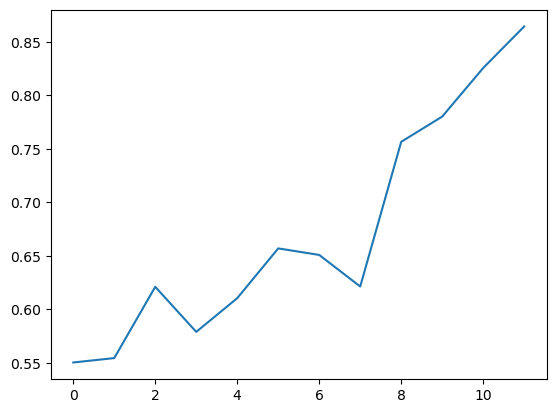

In [6]:
import matplotlib.pyplot as plt

plt.plot(acc_s)

In [11]:
base_acc_0 = validate(base_models[0], test_loader, criterion, device)[1]
base_acc_1 = validate(base_models[1], test_loader, criterion, device)[1]

base_acc_avg = (base_acc_0 + base_acc_1) / 2

Accuracy of the network on the 10000 test images: 89 
Accuracy of the network on the 10000 test images: 89 


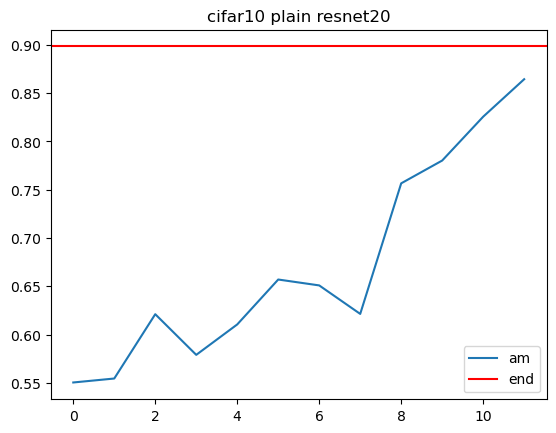

In [14]:
plt.plot(am_acc_s, label='am')
# plt.plot(acc_s, label='zipit')
# plot the base model accuracy
plt.axhline(y=base_acc_avg, color='r', linestyle='-', label='end')
plt.title('cifar10 plain resnet20')
plt.legend()

In [9]:
am_acc_s = acc_s

In [ ]:
conv_idx_s = []

for idx, m in enumerate(base_models[0].features):
    if isinstance(m, torch.nn.Conv2d):
        conv_idx_s.append(idx)
conv_idx_s

[0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]

In [ ]:
total_nodes = list(Merge.merges.keys())
base_model_merge_s = [deepcopy(base_model) for base_model in base_models]

for model_idx, base_model_merge in enumerate(base_model_merge_s):
    for i, (last_node, node, conv_idx) in enumerate(zip([None]+total_nodes[:-1], total_nodes, conv_idx_s[-len(total_nodes):])):
        layer = base_model_merge.features[conv_idx]
        merge_matrix = Merge.merges[node][model_idx]
        if i > 0:
            unmerge_matrix = Merge.unmerges[last_node][model_idx]
            layer.weight.data = torch.einsum('OIHW,IU->OUHW', layer.weight.data, unmerge_matrix)
        layer.weight.data = torch.einsum('UO,OIHW->UIHW', merge_matrix, layer.weight.data)
        if hasattr(layer, 'bias') and layer.bias is not None:
            layer.bias.data = merge_matrix @ layer.bias.data
    unmerge_matrix = Merge.unmerges[node][model_idx]
    base_model_merge.classifier[0].weight.data = base_model_merge.classifier[0].weight.data @ unmerge_matrix

In [ ]:
validate(base_model_merge_s[1], test_loader, criterion, device)

Accuracy of the network on the 10000 test images: 90 


(0.005323638924211263, 0.9097)

In [ ]:
from lmc_utils import interpolate_state_dicts

sd_mid = interpolate_state_dicts(base_model_merge_s[1].state_dict(), base_model_merge_s[0].state_dict(), 0.5)

In [ ]:
for k in sd_mid.keys():
    print(k,":",  (sd_mid[k] - Merge.merged_model.state_dict()[k]).abs().max().item())

features.0.weight : 0.0
features.0.bias : 0.0
features.2.weight : 0.0
features.2.bias : 0.0
features.5.weight : 0.0
features.5.bias : 0.0
features.7.weight : 0.0
features.7.bias : 0.0
features.10.weight : 0.0
features.10.bias : 0.0
features.12.weight : 0.0
features.12.bias : 0.0
features.14.weight : 0.0
features.14.bias : 0.0
features.17.weight : 0.0
features.17.bias : 0.0
features.19.weight : 0.0
features.19.bias : 0.0
features.21.weight : 0.0
features.21.bias : 0.0
features.24.weight : 0.0
features.24.bias : 0.0
features.26.weight : 0.0
features.26.bias : 0.0
features.28.weight : 0.0
features.28.bias : 0.0
classifier.0.weight : 0.0
classifier.0.bias : 0.0


In [ ]:
sd_mid['features.24.weight'] - Merge.merged_model.state_dict()['features.24.weight']

tensor([[[[-4.0047e-08, -4.0163e-09,  3.6089e-09],
          [-4.0047e-08,  1.9325e-08,  1.4261e-09],
          [-2.9802e-08,  2.0489e-08, -3.3760e-09]],

         [[ 3.4459e-08,  2.3749e-08, -2.7358e-09],
          [ 7.1712e-08,  4.2492e-09, -2.8522e-09],
          [-1.7462e-09,  5.3551e-09, -5.5297e-10]],

         [[-6.7055e-08,  2.1420e-08, -3.0850e-09],
          [-7.3342e-09,  1.9325e-08,  2.5611e-09],
          [-2.4447e-09,  3.3178e-09, -1.5134e-09]],

         ...,

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]],


        [[[-7.2177e-09, -1.6065e-08, -5.3551e-09],
  

#### unzip early layers

In [ ]:
from models import my_vgg, my_vgg_bn

def partial_zip_model(x, start_at_models, merged_model, nodes, merge_node):
    if start_at_models is None:
        return merged_model(x)
    merge_node_id = int(nodes[merge_node]['layer'].split('.')[-1])
    coefs = [1/len(start_at_models)] * len(start_at_models)
    unzip_output = None
    for i, start_at_model in enumerate(start_at_models):
        if unzip_output is None:
            unzip_output = start_at_model.features[:merge_node_id+1](x) * coefs[i]
        else:
            unzip_output += start_at_model.features[:merge_node_id+1](x) * coefs[i]
    zip_conv_output = merged_model.features[merge_node_id+1:](unzip_output)
    
    out = merged_model.avgpool(zip_conv_output)
    out = torch.flatten(out, 1)
    out = merged_model.classifier(out)
    return out

In [ ]:
prefix_nodes, len(prefix_nodes)

([3, 6, 10, 13, 17, 20, 23, 27, 30, 33, 37, 40, 43], 13)

In [ ]:
start_at = prefix_nodes[-1]
stop_at = None
merging_fn = 'match_tensors_permute'

graphs = [Grapher(deepcopy(base_model)).graphify() for base_model in base_models]
Merge = ModelMerge(*graphs, device=device)
Merge.transform(
    deepcopy(config['models']['new']), 
    train_loader, 
    transform_fn=get_merging_fn(merging_fn),
    metric_classes=config['metric_fns'],
    stop_at=stop_at,
    start_at=start_at
)

validate(Merge, test_loader, criterion, device)

Forward Pass to Compute Merge Metrics:   0%|          | 0/391 [00:00<?, ?it/s]

Computing transformations:   0%|          | 0/13 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 93 


(0.002283796424418688, 0.9318)

In [ ]:
Merge.clear_hooks()

if 'bn' not in config_name:
    merged_model = my_vgg.my_vgg16()
    offset = 2
else:
    merged_model = my_vgg_bn.my_vgg16_bn()
    offset = 3

merged_sd = Merge.get_merged_state_dict()
merged_model.load_state_dict(deepcopy(merged_sd))
merged_model = merged_model.to(device)

merged_model.eval()

# validate
correct = 0
total = 0
nodes = graphs[0].G.nodes
# start_at = prefix_nodes[1]
merge_node = start_at - offset if start_at is not None else None

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if start_at is None:
            outputs = merged_model(images)
        else:
            outputs = partial_zip_model(images, Merge.start_at_models, merged_model, nodes, merge_node)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: {}'.format(100 * correct / total))


Accuracy of the network on the 10000 test images: 93.18


In [ ]:
### for debugging

# total = 0
# correct = 0

# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         images = images.to(device)
#         labels = labels.to(device)
        
#         ou1_1 = Merge.start_at_models[0].features[0](images)
#         ou1_2 = Merge.start_at_models[1].features[0](images) 
#         out = (ou1_1 + ou1_2) / 2 / 2
        
#         outputs = merged_model.features[1:](out)
#         outputs = merged_model.avgpool(outputs)
#         outputs = torch.flatten(outputs, 1)
#         outputs = merged_model.classifier(outputs)

#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# print('Accuracy of the network on the 10000 test images: {}'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 46.0


#### apply repair/rescale

In [ ]:
def bn_calibration_init(m):
    """ calculating post-statistics of batch normalization """
    if getattr(m, 'track_running_stats', False):
        # reset all values for post-statistics
        m.reset_running_stats()
        # set bn in training mode to update post-statistics
        m.training = True
        # use cumulative moving average
        m.momentum = None

In [ ]:
Merge

In [ ]:
from lmc_utils import repair, BatchScale2d

Merge.clear_hooks()


repaired_merged_model = repair(train_loader, base_models, Merge.merged_model, device, name='vgg16', variant='repair', reset_bn=False)
# nodes = graphs[0].G.nodes
# merge_node = start_at - offset if start_at is not None else None

# merged_model = my_vgg.my_vgg16()
# merged_sd = Merge.get_merged_state_dict()
# merged_model.load_state_dict(merged_sd)
# merged_model = merged_model.to(device)
# merged_model = Merge.merged_model

# reset bn
repaired_merged_model.train()
for m in repaired_merged_model.modules():
    if isinstance(m, (torch.nn.BatchNorm2d, BatchScale2d)):
        bn_calibration_init(m)
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = partial_zip_model(images, Merge.start_at_models, repaired_merged_model, nodes, merge_node)
        # outputs = repaired_merged_model(images)
reset_bn_stats(repaired_merged_model, train_loader)


total = 0
correct = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if start_at is None:
            outputs = repaired_merged_model(images)
        else:
            outputs = partial_zip_model(images, Merge.start_at_models, repaired_merged_model, nodes, merge_node)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: {}'.format(100 * correct / total))


Resetting batch norm:   0%|          | 0/391 [00:00<?, ?it/s]

Resetting batch norm:   0%|          | 0/391 [00:00<?, ?it/s]

Resetting batch norm:   0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 45.71


In [ ]:
from lmc_utils import repair

Merge.clear_hooks()
repaired_merged_model = repair(train_loader, base_models, Merge.merged_model, device, name='vgg16', variant='repair', reset_bn=False)

total = 0
correct = 0

# repaired_merged_model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if start_at is None:
            outputs = repaired_merged_model(images)
        else:
            outputs = partial_zip_model(images, Merge.start_at_models, repaired_merged_model, nodes, merge_node)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: {}'.format(100 * correct / total))

Resetting batch norm:   0%|          | 0/391 [00:00<?, ?it/s]

Resetting batch norm:   0%|          | 0/391 [00:00<?, ?it/s]














Accuracy of the network on the 10000 test images: 81.84


#### Remove bias

In [ ]:
if 'bn' not in config_name:
    merged_model = my_vgg.my_vgg16()
    offset = 2
else:
    merged_model = my_vgg_bn.my_vgg16_bn()
    offset = 3

merged_sd = deepcopy(Merge.get_merged_state_dict())
# set bias to zero from 'merged_sd'
for k in merged_sd.keys():
    if 'bias' in k:
        merged_sd[k].fill_(0)
merged_model.load_state_dict(merged_sd)
merged_model = merged_model.to(device)

Merge.clear_hooks()

# validate
correct = 0
total = 0
nodes = graphs[0].G.nodes
merge_node = start_at - offset if start_at is not None else None

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if start_at is None:
            outputs = merged_model(images)
        else:
            outputs = partial_zip_model(images, Merge.start_at_models, merged_model, nodes, merge_node)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: {}'.format(100 * correct / total))


Accuracy of the network on the 10000 test images: 83.19


#### Homogeneous interpolation

In [ ]:
from lmc_utils import interpolate_state_dicts

if 'bn' not in config_name:
    merged_model = my_vgg.my_vgg16()
    offset = 2
else:
    merged_model = my_vgg_bn.my_vgg16_bn()
    offset = 3
    
merged_sd = Merge.get_merged_state_dict()
merged_sd = interpolate_state_dicts(merged_sd, merged_sd, 0.5, True)
merged_model.load_state_dict(deepcopy(merged_sd))
merged_model = merged_model.to(device)

Merge.clear_hooks()

# validate
correct = 0
total = 0
nodes = graphs[0].G.nodes
merge_node = start_at - offset if start_at is not None else None

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if start_at is None:
            outputs = merged_model(images)
        else:
            outputs = partial_zip_model(images, Merge.start_at_models, merged_model, nodes, merge_node)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: {}'.format(100 * correct / total))


Accuracy of the network on the 10000 test images: 84.31


## vgg16 bn

In [ ]:
from models import my_vgg_bn
import torch

model = my_vgg_bn.my_vgg16_bn()
sd = torch.load('checkpoints/cifar10_my_vgg16_bn_1.pt', weights_only=True, map_location='cpu')
model.load_state_dict(sd)

/home/xingyu/anaconda3/envs/default/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


<All keys matched successfully>

In [ ]:

import os
import torch
import random

from copy import deepcopy
from tqdm.auto import tqdm
import numpy as np

from utils import *
from model_merger import ModelMerge

def validate(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d ' % (100 * correct / total))
    return loss_sum / total, correct / total

config_name = 'cifar10_my_vgg16_bn'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
raw_config = get_config_from_name(config_name, device=device)  # 返回config文件中的字典，添加了一个device键值对
cur_config = deepcopy(raw_config)
config = prepare_experiment_config(cur_config)

train_loader = config['data']['train']['full']
test_loader = config['data']['test']['full']

Files already downloaded and verified
Files already downloaded and verified


Preparing Models:   0%|          | 0/2 [00:00<?, ?it/s]

/home/xingyu/anaconda3/envs/default/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
validate(model, test_loader, torch.nn.CrossEntropyLoss(), device)

Accuracy of the network on the 10000 test images: 93 


(0.002592544361948967, 0.9346)

## Cifar100 experiment

In [ ]:
from models import my_vgg_bn
import torch

model = my_vgg_bn.my_vgg16_bn(num_classes=100)
sd = torch.load('checkpoints/cifar100_my_vgg16_bn_1.pt', weights_only=True, map_location='cpu')
model.load_state_dict(sd)

/home/xingyu/anaconda3/envs/default/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


<All keys matched successfully>

In [ ]:
import os
import torch
import random

from copy import deepcopy
from tqdm.auto import tqdm
import numpy as np

from utils import *
from model_merger import ModelMerge

def validate(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d ' % (100 * correct / total))
    return loss_sum / total, correct / total

config_name = 'cifar100_my_vgg16_bn'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
raw_config = get_config_from_name(config_name, device=device)  # 返回config文件中的字典，添加了一个device键值对
cur_config = deepcopy(raw_config)
config = prepare_experiment_config(cur_config)

train_loader = config['data']['train']['full']
test_loader = config['data']['test']['full']

100%|██████████| 169M/169M [00:14<00:00, 11.9MB/s] 


Extracting ./data/cifar-100-python/cifar-100-python.tar.gz to ./data/cifar-100-python
Files already downloaded and verified


Preparing Models:   0%|          | 0/2 [00:00<?, ?it/s]

/home/xingyu/anaconda3/envs/default/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
validate(model, test_loader, torch.nn.CrossEntropyLoss(), device)

Accuracy of the network on the 10000 test images: 72 


(0.011370930874347688, 0.725)

## Test ResNet

In [ ]:
from models import resnets, my_resnet
from models.my_resnet import ResNet
from graphs import resnet_graph, my_resnet_graph
from graphs.base_graph import NodeType
from torch.utils.data import TensorDataset, DataLoader
from model_merger import ModelMerge
from matching_functions import match_tensors_zipit
import torch
from copy import deepcopy   

model = ResNet.get_model_from_name('cifar_resnet20')
graph = my_resnet_graph.my_resnet20(model).graphify()

In [ ]:
data_x = torch.rand(4, 3, 224, 224)
data_y = torch.zeros(4)

dataset = TensorDataset(data_x, data_y)
dataloader = DataLoader(dataset, batch_size=4)

model = ResNet.get_model_from_name('cifar_resnet20').eval()
model3 = ResNet.get_model_from_name('cifar_resnet20').eval()

sd = torch.load('checkpoints/cifar10_my_resnet20_1.pt', weights_only=True, map_location='cpu')
sd3 = torch.load('checkpoints/cifar10_my_resnet20_2.pt', weights_only=True, map_location='cpu')

model.load_state_dict(sd)
model3.load_state_dict(sd3)

graph1 = my_resnet_graph.my_resnet20(deepcopy(model)).graphify()
graph2 = my_resnet_graph.my_resnet20(deepcopy(model)).graphify()

merge = ModelMerge(graph1, graph2)
merge.transform(model3, dataloader, transform_fn=match_tensors_zipit)

# graph1.draw(nodes=range(20))
# graph1.draw(nodes=range(len(graph1.G)-20, len(graph1.G)))

print(model.eval().cuda()(data_x.cuda()))

print(merge(data_x.cuda()))

Forward Pass to Compute Merge Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Computing transformations:   0%|          | 0/12 [00:00<?, ?it/s]

tensor([[-2.2492, -6.3151,  2.5010,  7.2556,  5.4146, -1.8805,  9.3524, -6.6643,
         -2.5210, -4.8553],
        [-2.0062, -6.3814,  2.7688,  7.1656,  5.4354, -2.0123,  9.4195, -6.6743,
         -2.8069, -4.8704],
        [-2.2880, -6.2412,  2.8847,  7.0470,  5.4902, -2.1516,  9.1518, -6.5387,
         -2.5343, -4.7824],
        [-1.9479, -6.3449,  2.6495,  6.9276,  5.3709, -2.1345,  9.4511, -6.6088,
         -2.5630, -4.7621]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.7602, -5.8745,  3.6794,  8.3134,  4.4691, -0.6432,  6.9592, -6.0441,
         -2.6446, -5.4183],
        [-2.6320, -6.0002,  3.8670,  8.1926,  4.6107, -0.7224,  6.9830, -5.9210,
         -2.9057, -5.4355],
        [-2.7136, -5.8247,  4.0251,  8.2618,  4.6143, -0.8939,  6.5677, -5.8428,
         -2.7307, -5.4282],
        [-2.4599, -5.8956,  3.7717,  8.0401,  4.5599, -0.9631,  6.9661, -5.8810,
         -2.7297, -5.3726]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
prefix_idx_s = []
for idx, node in graph.G.nodes.items():
    if node['type'] == NodeType.PREFIX:
        prefix_idx_s.append(idx)
prefix_idx_s

[5, 11, 17, 21, 26, 32, 38, 42, 47, 53, 59, 63]

## Visualize

### calculate params/flops

In [170]:
from graphs import my_vgg_bn_graph
from models import my_vgg_bn
from graphs.base_graph import NodeType

model = my_vgg_bn.my_vgg16_bn()
graph = my_vgg_bn_graph.my_vgg16_bn(model).graphify()

In [171]:
prefix_idx_s = []

for idx, node in graph.G.nodes.items():
    if node['type'] == NodeType.PREFIX:
        prefix_idx_s.append(idx)

prefix_idx_s

[4, 8, 13, 17, 22, 26, 30, 35, 39, 43, 48, 52, 56]

In [1]:
import numpy as np
import pandas as pd

def doubling_shape(shape_str):
    shape = shape_str.split(' ')
    for i, c in enumerate(shape):
        try:
            shape[i] = str(int(c)*2)
        except:
            pass
    return ' '.join(shape)

def report_zipit_at_layer_flops(report_df, layer, flops_multiply_factor=2):
    report_df = report_df.drop(['memory(MB)', 'MAdd', 'MemRead(B)', 'MemWrite(B)', 'duration[%]', 'MemR+W(B)'], axis=1).copy()
    
    report_df['Flops'] = report_df['Flops'].replace({',': ''}, regex=True).astype(float)

    input_shape_s = report_df['input shape'].apply(lambda x: x.strip().split(' ')[0]).to_numpy()
    input_shape_s = input_shape_s[input_shape_s != '']
    input_shape_s = input_shape_s.astype(int)
    
    if layer > 0:
        report_df.loc[:layer-1, 'Flops'] *= flops_multiply_factor
        report_df.loc[:layer-1, 'params'] *= 2
        report_df.loc[:layer-1, 'input shape'] = report_df.loc[:layer-1, 'output shape'].apply(doubling_shape)
        report_df.loc[:layer-1, 'output shape'] = report_df.loc[:layer-1, 'output shape'].apply(doubling_shape)
        
        zip_row = report_df.iloc[layer-1].copy()
        zip_row['module name'] = 'merge acts'
        zip_row['input shape'] = report_df['output shape'].iloc[layer-1]
        input_shape = int(zip_row['input shape'].strip().split(' ')[0])
        if layer < len(report_df) - 1:
            zip_row['output shape'] = report_df['input shape'].iloc[layer]
            output_shape = int(zip_row['output shape'].strip().split(' ')[0])
            assert(input_shape == output_shape * 2)
        
        zip_row['params'] = 0
        zip_row['Flops'] = input_shape
        report_df = pd.concat([report_df.iloc[:layer], pd.DataFrame([zip_row]), report_df.iloc[layer:]]).reset_index(drop=True)
        
        report_df.loc[report_df.index[-1], 'params'] = report_df['params'].iloc[:-1].sum()
        report_df.loc[report_df.index[-1], 'Flops'] = report_df['Flops'].iloc[:-1].sum()
    
    return report_df

#### vgg16

In [12]:
from torchstat import stat
from models import my_vgg


model_new = my_vgg.my_vgg16().to('cpu')
num_features = len(model_new.features)

report, report_df = stat(model_new, (3, 32, 32))

merge_act_idx_s = []
# conv layer index
for i in range(num_features):
    if 'Conv2d' in model_new.features[i].__class__.__name__:
        merge_act_idx_s.append(i)
# for classifier
merge_act_idx_s.append(len(report_df)-2)
# for ensemble
merge_act_idx_s.append(len(report_df)-1)

report_df_zip_at_layer_s = []
for layer in merge_act_idx_s:
    report_df_zip_at_layer = report_zipit_at_layer_flops(report_df, layer)
    report_df_zip_at_layer_s.append(report_df_zip_at_layer)

param_s = [df.iloc[-1]['params'] for df in report_df_zip_at_layer_s]
flops_s = [df.iloc[-1]['Flops'] for df in report_df_zip_at_layer_s]
param_s = np.array(param_s)
flops_s = np.array(flops_s)

additioanl_param_pct = (param_s - param_s[0]) / param_s[0]
additioanl_flops_pct = (flops_s - flops_s[0]) / flops_s[0]

[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!


/home/xingyu/anaconda3/envs/default/lib/python3.11/site-packages/torchstat/reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)
/tmp/ipykernel_1831640/920147618.py:23: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  report_df.loc[:layer-1, 'Flops'] *= flops_multiply_factor
/tmp/ipykernel_1831640/920147618.py:24: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  report_df.loc[:layer-1, 'params'] *= 2
/tmp/ipykernel_1831640/920147618.py:25: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  report_df.loc[:layer-1, 'input shape'] = report_df.loc[:layer-1, 'output sha

In [14]:
report_df.to_csv('reports/vgg16_report.csv')

#### vgg16_bn

In [15]:
from torchstat import stat
from models import my_vgg_bn


model_new = my_vgg_bn.my_vgg16_bn().to('cpu')
num_features = len(model_new.features)

report, report_df = stat(model_new, (3, 32, 32))

[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!


/home/xingyu/anaconda3/envs/default/lib/python3.11/site-packages/torchstat/reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [5]:
params = report_df['params'][:-1]
# remove all the zero; reset index
params = params[params != 0]
params = params.reset_index(drop=True)

In [6]:
# for vgg16 bn
def calculate_param_num(params, M):
    factor = 2
    total = params.sum()
    cur = 0
    if M == 14:
        cur = 2 * total
    elif M == 0:
        cur = total
    else:
        cur += (params[:factor*M]*2).sum()
        cur += params[factor*M:].sum()
    return cur, cur/total

In [16]:
print(calculate_param_num(params, 0))
print(calculate_param_num(params, 3))
print(calculate_param_num(params, 7))
print(calculate_param_num(params, 10))
print(calculate_param_num(params, 12))
print(calculate_param_num(params, 14))

(14728266.0, 1.0)
(14841354.0, 1.0076782969563423)
(16466058.0, 1.1179902644343875)
(22368906.0, 1.5187739004713794)
(27090570.0, 1.8393590935959467)
(29456532.0, 2.0)


In [17]:
report_df.to_csv('reports/vgg16_bn_report.csv')

flops

In [28]:
relu_idx = []
for i, m in enumerate(model_new.features):
    if 'ReLU' in m.__class__.__name__:
        relu_idx.append(i)
relu_idx

[2, 5, 9, 12, 16, 19, 22, 26, 29, 32, 36, 39, 42]

In [29]:
flops = report_df['Flops'][:-1]
flops = flops.replace({',': ''}, regex=True).astype(float)
output_shape_s = report_df['output shape'].apply(lambda x: x.strip().split(' ')[0]).to_numpy()
output_shape_s = output_shape_s[output_shape_s != '']
output_shape_s = output_shape_s.astype(int)
preserve_until = [0] + relu_idx + [44]

In [30]:
preserve_until

[0, 2, 5, 9, 12, 16, 19, 22, 26, 29, 32, 36, 39, 42, 44]

In [31]:
len(preserve_until)

15

In [32]:
# for vgg16 bn
def calculate_flop_num(flops, output_shape_s, preserve_until, M):
    total = flops.sum()
    
    idx = preserve_until[M]
    merge_flops = output_shape_s[idx]*2
    cur = 0
    if M == 14:
        cur = 2 * total + merge_flops
    elif M == 0:
        cur = total
    else:
        cur += (flops[:idx+1]*2).sum()
        cur += merge_flops
        cur += flops[idx+1:].sum()
    return cur/1e9, cur/total

In [34]:
print(calculate_flop_num(flops, output_shape_s, preserve_until, 0))
print(calculate_flop_num(flops, output_shape_s, preserve_until, 3))
print(calculate_flop_num(flops, output_shape_s, preserve_until, 7))
print(calculate_flop_num(flops, output_shape_s, preserve_until, 10))
print(calculate_flop_num(flops, output_shape_s, preserve_until, 12))
print(calculate_flop_num(flops, output_shape_s, preserve_until, 14))

(0.314432512, 1.0)
(0.37354624, 1.1880013222042383)
(0.50602752, 1.6093358691864537)
(0.60051456, 1.9098360922677105)
(0.619413504, 1.9699410218749898)
(0.628865044, 2.000000063606654)


### resnet20

In [18]:
from torchstat import stat
from models import my_resnet
from graphs import my_resnet_graph
from graphs.base_graph import NodeType

model_new = my_resnet.ResNet.get_model_from_name('cifar_resnet20')
graph = my_resnet_graph.my_resnet20(model_new).graphify()

report, report_df = stat(model_new, (3, 32, 32))
report_df['Flops'] = report_df['Flops'].replace({',': ''}, regex=True).astype(float)

[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Seq

/home/xingyu/anaconda3/envs/default/lib/python3.11/site-packages/torchstat/reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [19]:
report_df.to_csv('reports/resnet20_report.csv')

In [152]:
prefix_idx_s = []
util_layer_name_s = []
for node in graph.G.nodes:
    if graph.G.nodes[node]['type'] == NodeType.PREFIX:
        prefix_idx_s.append(node)
        if graph.G.nodes[node-1]['layer'] is None:
            util_layer_name_s.append(graph.G.nodes[node-2]['layer'])
        else:
            util_layer_name_s.append(graph.G.nodes[node-1]['layer'])
print(prefix_idx_s)
print(util_layer_name_s)

[5, 11, 17, 21, 26, 32, 38, 42, 47, 53, 59, 63]
['segments.0.0.norm1', 'segments.0.1.norm1', 'segments.0.2.norm1', 'segments.0.2.norm2', 'segments.1.0.norm1', 'segments.1.1.norm1', 'segments.1.2.norm1', 'segments.1.2.norm2', 'segments.2.0.norm1', 'segments.2.1.norm1', 'segments.2.2.norm1', 'segments.2.2.norm2']


In [156]:
def calculate_num_flops(graph, report_df, prefix_idx_s, M):
    # M=1,...,13
    M = M - 1
    sum_param = 0
    sum_flops = 0
    total_layer = 0
    num_layers = 0
    prefix_id = prefix_idx_s[M]
    
    total_params = report_df['params']['total']
    total_flops = report_df['Flops']['total']

    for node in graph.G.nodes:
        node_name = graph.G.nodes[node]['layer']
        
        if node_name not in report_df['module name'].values:
            continue
        else:
            if report_df['params'][report_df['module name']==node_name].values[0] > 0:
                if 'norm' not in node_name and 'shortcut' not in node_name:
                    total_layer += 1
            if node <= prefix_id:
                sum_param += report_df['params'][report_df['module name']==node_name].values[0]*2
                sum_flops += report_df['Flops'][report_df['module name']==node_name].values[0]*2
                if report_df['params'][report_df['module name']==node_name].values[0] > 0:
                    if 'norm' not in node_name and 'shortcut' not in node_name:
                        num_layers += 1
            else:
                sum_param += report_df['params'][report_df['module name']==node_name].values[0]
                sum_flops += report_df['Flops'][report_df['module name']==node_name].values[0]
    return sum_param/1e6, sum_param/total_params, sum_flops/1e6, sum_flops/total_flops, num_layers, total_layer

In [153]:
len(prefix_idx_s)

12

In [157]:
print(calculate_num_flops(graph, report_df, prefix_idx_s, 3))
print(calculate_num_flops(graph, report_df, prefix_idx_s, 6))
print(calculate_num_flops(graph, report_df, prefix_idx_s, 8))
print(calculate_num_flops(graph, report_df, prefix_idx_s, 12))

(0.284618, 1.044569390106946, 53.650048, 1.301724593076161, 6, 20)
(0.310762, 1.1405198294149166, 62.13696, 1.5076446710912486, 10, 20)
(0.338602, 1.2426947158260973, 69.264, 1.6805698331309455, 13, 20)
(0.544298, 1.9976144512870952, 82.428544, 1.9999844715192134, 19, 20)


In [158]:
total_params = report_df['params']['total']
total_flops = report_df['Flops']['total']
print(total_params/1e6, total_flops/1e6)    

0.272474 41.214592


In [159]:
report_df

,module name,input shape,output shape,params,memory(MB),MAdd,Flops,MemRead(B),MemWrite(B),duration[%],MemR+W(B)
0,conv1,3 32 32,16 32 32,432.0,0.06,"868,352.0",442368.0,14016.0,65536.0,6.12%,79552.0
1,norm1,16 32 32,16 32 32,32.0,0.06,"65,536.0",32768.0,65664.0,65536.0,5.34%,131200.0
2,avg_pool,64 8 8,64 1 1,0.0,0.00,0.0,0.0,0.0,0.0,1.17%,0.0
3,segments.0.0.conv1,16 32 32,16 32 32,2304.0,0.06,"4,702,208.0",2359296.0,74752.0,65536.0,9.13%,140288.0
4,segments.0.0.norm1,16 32 32,16 32 32,32.0,0.06,"65,536.0",32768.0,65664.0,65536.0,7.57%,131200.0
5,segments.0.0.conv2,16 32 32,16 32 32,2304.0,0.06,"4,702,208.0",2359296.0,74752.0,65536.0,7.63%,140288.0
6,segments.0.0.norm2,16 32 32,16 32 32,32.0,0.06,"65,536.0",32768.0,65664.0,65536.0,1.84%,131200.0
7,segments.0.0.shortcut,16 32 32,16 32 32,0.0,0.06,0.0,0.0,0.0,0.0,1.19%,0.0
8,segments.0.1.conv1,16 32 32,16 32 32,2304.0,0.06,"4,702,208.0",2359296.0,74752.0,65536.0,2.13%,140288.0
9,segments.0.1.norm1,16 32 32,16 32 32,32.0,0.06,"65,536.0",32768.0,65664.0,65536.0,1.49%,131200.0


In [160]:
# remove zero; reset index
params = report_df['params']
params = params[params != 0]
params = params.reset_index(drop=True)
params

0        432.0
1         32.0
2       2304.0
3         32.0
4       2304.0
5         32.0
6       2304.0
7         32.0
8       2304.0
9         32.0
10      2304.0
11        32.0
12      2304.0
13        32.0
14      4608.0
15        64.0
16      9216.0
17        64.0
18       512.0
19        64.0
20      9216.0
21        64.0
22      9216.0
23        64.0
24      9216.0
25        64.0
26      9216.0
27        64.0
28     18432.0
29       128.0
30     36864.0
31       128.0
32      2048.0
33       128.0
34     36864.0
35       128.0
36     36864.0
37       128.0
38     36864.0
39       128.0
40     36864.0
41       128.0
42       650.0
43    272474.0
Name: params, dtype: float64

#### resnet50

In [21]:
from torchstat import stat
from models import my_resnet
from graphs import resnet_graph
from graphs.base_graph import NodeType
import torchvision.models as models

model_new = models.resnet50()
graph = resnet_graph.resnet50(model_new).graphify()

report, report_df = stat(model_new, (3, 32, 32))
report_df['Flops'] = report_df['Flops'].replace({',': ''}, regex=True).astype(float)

[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Sequential is not supported!
[MAdd]: Sequential is not supported!
[Flops]: Sequential is not supported!
[Memory]: Seq

/home/xingyu/anaconda3/envs/default/lib/python3.11/site-packages/torchstat/reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [22]:
report_df.to_csv('reports/resnet50_report.csv')

In [164]:
prefix_idx_s = []
util_layer_name_s = []
for node in graph.G.nodes:
    if graph.G.nodes[node]['type'] == NodeType.PREFIX:
        prefix_idx_s.append(node)
        if graph.G.nodes[node-1]['layer'] is None:
            util_layer_name_s.append(graph.G.nodes[node-2]['layer'])
        else:
            util_layer_name_s.append(graph.G.nodes[node-1]['layer'])
print(prefix_idx_s)
print(util_layer_name_s)

[3, 8, 11, 17, 20, 26, 29, 33, 38, 41, 47, 50, 56, 59, 65, 68, 72, 77, 80, 86, 89, 95, 98, 104, 107, 113, 116, 122, 125, 129, 134, 137, 143, 146, 152, 155, 159]
['bn1', 'layer1.0.bn1', 'layer1.0.bn2', 'layer1.1.bn1', 'layer1.1.bn2', 'layer1.2.bn1', 'layer1.2.bn2', 'layer1.2.bn3', 'layer2.0.bn1', 'layer2.0.bn2', 'layer2.1.bn1', 'layer2.1.bn2', 'layer2.2.bn1', 'layer2.2.bn2', 'layer2.3.bn1', 'layer2.3.bn2', 'layer2.3.bn3', 'layer3.0.bn1', 'layer3.0.bn2', 'layer3.1.bn1', 'layer3.1.bn2', 'layer3.2.bn1', 'layer3.2.bn2', 'layer3.3.bn1', 'layer3.3.bn2', 'layer3.4.bn1', 'layer3.4.bn2', 'layer3.5.bn1', 'layer3.5.bn2', 'layer3.5.bn3', 'layer4.0.bn1', 'layer4.0.bn2', 'layer4.1.bn1', 'layer4.1.bn2', 'layer4.2.bn1', 'layer4.2.bn2', 'layer4.2.bn3']


In [165]:
def calculate_num_flops(graph, report_df, prefix_idx_s, M):
    # M=1,...,13
    M = M - 1
    sum_param = 0
    sum_flops = 0
    total_layer = 0
    num_layers = 0
    prefix_id = prefix_idx_s[M]
    
    total_params = report_df['params']['total']
    total_flops = report_df['Flops']['total']

    for node in graph.G.nodes:
        node_name = graph.G.nodes[node]['layer']
        
        if node_name not in report_df['module name'].values:
            continue
        else:
            if report_df['params'][report_df['module name']==node_name].values[0] > 0:
                if 'bn' not in node_name and 'downsample' not in node_name:
                    total_layer += 1
            if node <= prefix_id:
                sum_param += report_df['params'][report_df['module name']==node_name].values[0]*2
                sum_flops += report_df['Flops'][report_df['module name']==node_name].values[0]*2
                if report_df['params'][report_df['module name']==node_name].values[0] > 0:
                    if 'bn' not in node_name and 'downsample' not in node_name:
                        num_layers += 1
            else:
                sum_param += report_df['params'][report_df['module name']==node_name].values[0]
                sum_flops += report_df['Flops'][report_df['module name']==node_name].values[0]
    return sum_param/1e6, sum_param/total_params, sum_flops/1e9, sum_flops/total_flops, num_layers, total_layer

In [166]:
len(prefix_idx_s)

37

In [176]:
import numpy as np
import torch
preserverd_num = [0]
param_ratio = [1]
flops_ratio = [1]
for i in range(1, 37):
    arr = np.array(calculate_num_flops(graph, report_df, prefix_idx_s, i))
    param_ratio.append(arr[1]) 
    flops_ratio.append(arr[3])
    preserverd_num.append(arr[4])
    print(f"i: {i}", arr[[1, 3, 4]])

preserverd_num += [50]
param_ratio += [2]
flops_ratio += [2]

param_ratio = np.array(param_ratio)
flops_ratio = np.array(flops_ratio)
preserverd_num = np.array(preserverd_num)
res_dict = {'param_ratio': param_ratio, 'flops_ratio': flops_ratio, 'preserverd_num': preserverd_num}
torch.save(res_dict, 'resnet50_pfm_details.pt')

i: 1 [1.00037313 1.02667746 1.        ]
i: 2 [1.00119951 1.04238407 2.        ]
i: 3 [1.00264694 1.06989446 3.        ]
i: 4 [1.00395414 1.09473947 5.        ]
i: 5 [1.00540157 1.12224985 6.        ]
i: 6 [1.00670876 1.14709487 8.        ]
i: 7 [1.00815619 1.17460525 9.        ]
i: 8 [ 1.0088173   1.18717055 10.        ]
i: 9 [ 1.01527814  1.23628943 11.        ]
i: 10 [ 1.02105784  1.26375222 12.        ]
i: 11 [ 1.02623654  1.28835925 14.        ]
i: 12 [ 1.03201624  1.31582204 15.        ]
i: 13 [ 1.03719493  1.34042908 17.        ]
i: 14 [ 1.04297463  1.36789186 18.        ]
i: 15 [ 1.04815332  1.3924989  20.        ]
i: 16 [ 1.05393302  1.41996169 21.        ]
i: 17 [ 1.05653739  1.4323366  22.        ]
i: 18 [ 1.0822806  1.4812651 23.       ]
i: 19 [ 1.10537937  1.50870408 24.        ]
i: 20 [ 1.12599397  1.53319213 26.        ]
i: 21 [ 1.14909274  1.56063112 27.        ]
i: 22 [ 1.16970734  1.58511917 29.        ]
i: 23 [ 1.19280611  1.61255816 30.        ]
i: 24 [ 1.21342071  1

In [ ]:
# params, 40, 80
# flops 40, 80 

In [168]:
total_params = report_df['params']['total']
total_flops = report_df['Flops']['total']
print(total_params/1e6, total_flops/1e9)

25.557032 0.086057984


In [145]:
report_df

,module name,input shape,output shape,params,memory(MB),MAdd,Flops,MemRead(B),MemWrite(B),duration[%],MemR+W(B)
0,conv1,3 32 32,64 16 16,9408.0,0.06,"4,800,512.0",2408448.0,49920.0,65536.0,2.15%,115456.0
1,bn1,64 16 16,64 16 16,128.0,0.06,"65,536.0",32768.0,66048.0,65536.0,1.01%,131584.0
2,relu,64 16 16,64 16 16,0.0,0.06,"16,384.0",16384.0,65536.0,65536.0,0.39%,131072.0
3,maxpool,64 16 16,64 8 8,0.0,0.02,"32,768.0",16384.0,65536.0,16384.0,0.44%,81920.0
4,layer1.0.conv1,64 8 8,64 8 8,4096.0,0.02,"520,192.0",262144.0,32768.0,16384.0,0.89%,49152.0
5,layer1.0.bn1,64 8 8,64 8 8,128.0,0.02,"16,384.0",8192.0,16896.0,16384.0,0.86%,33280.0
6,layer1.0.conv2,64 8 8,64 8 8,36864.0,0.02,"4,714,496.0",2359296.0,163840.0,16384.0,0.94%,180224.0
7,layer1.0.bn2,64 8 8,64 8 8,128.0,0.02,"16,384.0",8192.0,16896.0,16384.0,0.83%,33280.0
8,layer1.0.conv3,64 8 8,256 8 8,16384.0,0.06,"2,080,768.0",1048576.0,81920.0,65536.0,0.79%,147456.0
9,layer1.0.bn3,256 8 8,256 8 8,512.0,0.06,"65,536.0",32768.0,67584.0,65536.0,0.84%,133120.0


___

In [ ]:
import torch
import matplotlib.pyplot as plt

res_path = "vgg16_acc.pth"
res_dict = torch.load(res_path, weights_only=True)

In [ ]:
permute_res = res_dict['match_tensors_permute']
zipit_res = res_dict['match_tensors_zipit']
identity_res = res_dict['match_tensors_identity']

In [ ]:
permute_res['rescale']

[0.5749,
 0.6639333333333334,
 0.6809333333333333,
 0.6942666666666667,
 0.6887,
 0.7261666666666666,
 0.7381333333333333,
 0.7600666666666667,
 0.7883,
 0.8481666666666666,
 0.8953666666666666,
 0.9181333333333334,
 0.9163,
 0.9316]

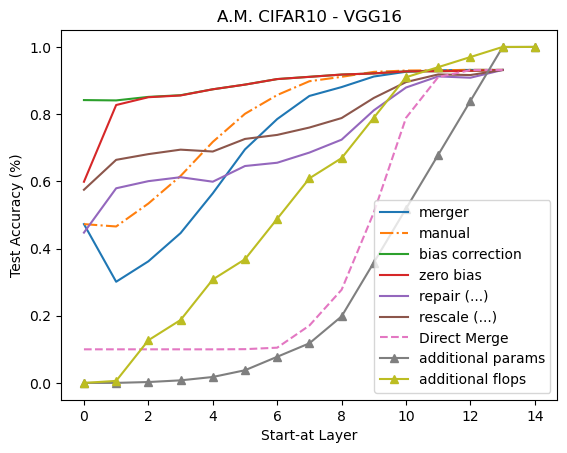

In [ ]:
x_s = range(0, len(permute_res['merger']))
model_name = 'VGG16'
merging_fn = 'match_tensors_permute'

plt.plot(x_s, permute_res['merger'], label='merger')
plt.plot(x_s, res_dict[merging_fn]['manual_acc'], label='manual', linestyle='-.')
plt.plot(x_s, res_dict[merging_fn]['bias_corr'], label='bias correction')
plt.plot(x_s, res_dict[merging_fn]['zero_bias'], label='zero bias')
plt.plot(x_s, res_dict[merging_fn]['repair'], label='repair (...)')
plt.plot(x_s, res_dict[merging_fn]['rescale'], label='rescale (...)')
plt.plot(x_s, identity_res['manual_acc'], label='Direct Merge', linestyle='--')
plt.plot(additioanl_param_pct, label='additional params', marker='^')
plt.plot(additioanl_flops_pct, label='additional flops', marker='^')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Start-at Layer')
# plt.xlim(6, 13)

plt.title(f'A.M. CIFAR10 - {model_name}')
plt.legend()

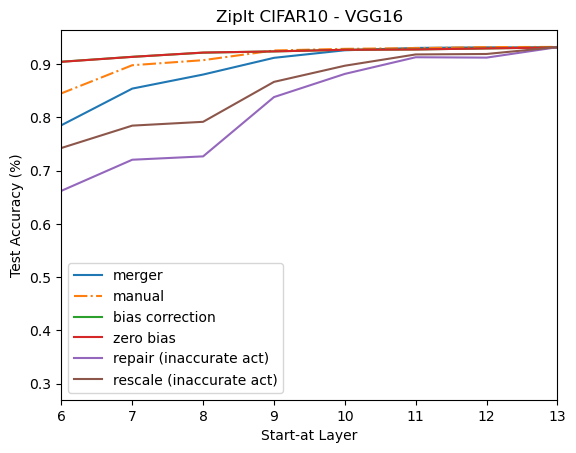

In [ ]:
x_s = range(0, len(permute_res['merger']))
model_name = 'VGG16'
merging_fn = 'match_tensors_zipit'

plt.plot(x_s, permute_res['merger'], label='merger')
plt.plot(x_s, res_dict[merging_fn]['manual_acc'], label='manual', linestyle='-.')
plt.plot(x_s, res_dict[merging_fn]['bias_corr'], label='bias correction')
plt.plot(x_s, res_dict[merging_fn]['zero_bias'], label='zero bias')
plt.plot(x_s, res_dict[merging_fn]['repair'], label='repair (inaccurate act)')
plt.plot(x_s, res_dict[merging_fn]['rescale'], label='rescale (inaccurate act)')
# plt.plot(x_s, res_dict['match_tensors_identity']['manual_acc'], label='Direct Merge', linestyle='--')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Start-at Layer')
plt.xlim(6, 13)

plt.title(f'ZipIt CIFAR10 - {model_name}')
plt.legend()

vgg16 bn

In [ ]:
import torch
import matplotlib.pyplot as plt

res_path = "vgg16_bn_acc.pth"
res_dict = torch.load(res_path, weights_only=True)

In [ ]:
permute_res = res_dict['match_tensors_permute']
zipit_res = res_dict['match_tensors_zipit']
identity_res = res_dict['match_tensors_identity']

In [ ]:
import torch
from copy import deepcopy
from utils import *
def validate(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d ' % (100 * correct / total))
    return loss_sum / total, correct / total

config_name = 'cifar10_my_vgg16_bn'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
raw_config = get_config_from_name(config_name, device=device)  # 返回config文件中的字典，添加了一个device键值对
cur_config = deepcopy(raw_config)
config = prepare_experiment_config(cur_config)
train_loader = config['data']['train']['full']
test_loader = config['data']['test']['full']
base_models = [base_model for base_model in config['models']['bases']]


Files already downloaded and verified
Files already downloaded and verified


Preparing Models:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
validate(base_models[0], test_loader, torch.nn.CrossEntropyLoss(), device)

Accuracy of the network on the 10000 test images: 93 


(0.002592544361948967, 0.9346)

In [2]:
import torch

torch.nn

AttributeError: module 'torch' has no attribute 'nn'

In [ ]:
validate(base_models[1], test_loader, torch.nn.CrossEntropyLoss(), device)

Accuracy of the network on the 10000 test images: 93 


(0.0026164365649223326, 0.9352)

In [ ]:
permute_res['merger_reset']

[0.897,
 0.8982,
 0.8967,
 0.903,
 0.9077,
 0.9166,
 0.9286,
 0.9373,
 0.94,
 0.9434,
 0.944,
 0.9431,
 0.9433,
 0.9437]

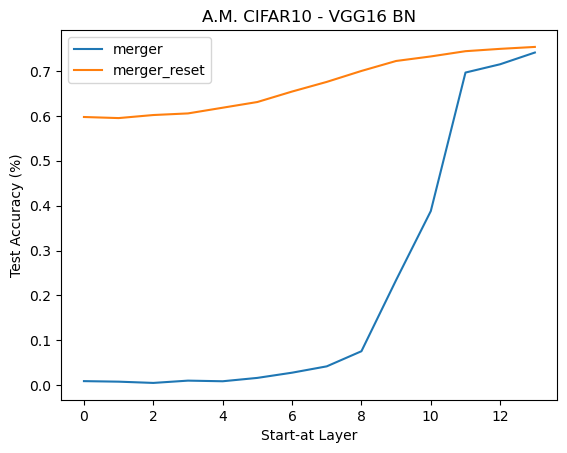

In [ ]:
x_s = range(0, len(permute_res['merger']))
model_name = 'VGG16 BN'

plt.plot(x_s, permute_res['merger'], label='merger')
plt.plot(x_s, permute_res['merger_reset'], label='merger_reset')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Start-at Layer')
# plt.xlim(6, 13)

plt.title(f'A.M. CIFAR10 - {model_name}')
plt.legend()

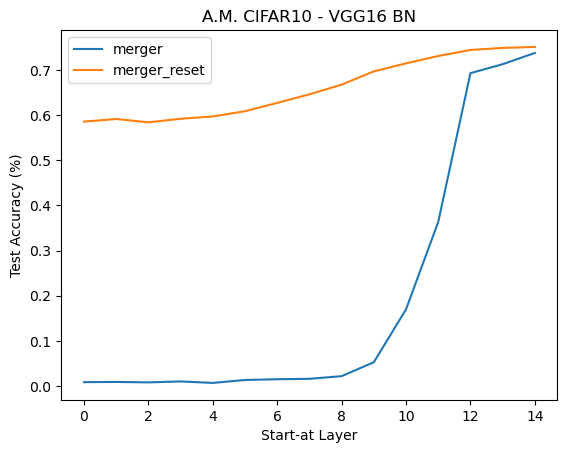

In [ ]:
x_s = range(0, len(zipit_res['merger']))
model_name = 'VGG16 BN'

plt.plot(x_s, zipit_res['merger'], label='merger')
plt.plot(x_s, zipit_res['merger_reset'], label='merger_reset')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Start-at Layer')
# plt.xlim(6, 13)

plt.title(f'A.M. CIFAR10 - {model_name}')
plt.legend()

In [ ]:
from torchstat import stat
from models import my_vgg_bn


model_new = my_vgg_bn.my_vgg16_bn().to('cpu')
num_features = len(model_new.features)

report, report_df = stat(model_new, (3, 32, 32))

merge_act_idx_s = []
# conv layer index
for i in range(num_features):
    if 'Conv2d' in model_new.features[i].__class__.__name__:
        merge_act_idx_s.append(i)
# for ensemble
merge_act_idx_s.append(len(report_df)-1)

report_df_zip_at_layer_s = []
for layer in merge_act_idx_s:
    report_df_zip_at_layer = report_zipit_at_layer_flops(report_df, layer)
    report_df_zip_at_layer_s.append(report_df_zip_at_layer)

param_s = [df.iloc[-1]['params'] for df in report_df_zip_at_layer_s]
flops_s = [df.iloc[-1]['Flops'] for df in report_df_zip_at_layer_s]
param_s = np.array(param_s)
flops_s = np.array(flops_s)

additioanl_param_pct = (param_s - param_s[0]) / param_s[0]
additioanl_flops_pct = (flops_s - flops_s[0]) / flops_s[0]

/home/xingyu/anaconda3/envs/default/lib/python3.11/site-packages/torchstat/reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)
/tmp/ipykernel_1236909/3453328922.py:24: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  report_df.loc[:layer-1, 'Flops'] *= flops_multiply_factor
/tmp/ipykernel_1236909/3453328922.py:25: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  report_df.loc[:layer-1, 'params'] *= 2
/tmp/ipykernel_1236909/3453328922.py:26: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  report_df.loc[:layer-1, 'input shape'] = report_df.loc[:layer-1, 'output 

In [ ]:
additioanl_param_pct

array([0.00000000e+00, 1.30361578e-04, 2.64634004e-03, 7.67829696e-03,
       1.77161385e-02, 3.77918215e-02, 7.78910430e-02, 1.17990264e-01,
       1.98188707e-01, 3.58481304e-01, 5.18773900e-01, 6.79066497e-01,
       8.39359094e-01, 1.00000000e+00])

In [ ]:
additioanl_flops_pct

array([0.        , 0.00646162, 0.12755729, 0.18800132, 0.30857593,
       0.36881194, 0.4890739 , 0.60938798, 0.66952059, 0.78967834,
       0.90986215, 0.93990158, 0.96994102, 1.00000006])